# Common Emitter

This document describes and simulates the BJT Common Emitter circuit

![Common Emitter](https://raw.githubusercontent.com/R6500/Python-bits/master/Colaboratory/Artwork/Common_Emitter.png)

Before working with this circuit we will load some Python modules.

**Execute** the following code to load the required Python modules.


In [ ]:
# The code is designed to work with Python 3.x
# To provide Python 2.7 compatibility, we can use two imports:
from __future__ import print_function
from __future__ import division

# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # We also load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py
    
# We load numpy, jplot and calc
import numpy as np
import calc

# Erase output after import
from IPython.display import clear_output
clear_output()

# Check loaded module
try:
    print('calc version: ',calc.version)
except:
    print('Error loading the calc module')

calc version:  15/3/2018-C


## Circuit parameters

Now we will define the circuit parameters

**Execute** the following code to do that

In [ ]:
# Input signal amplitude
# Nominal valur is 0.01 (10 mV)
# Use a 0.2 value to see the saturation effect
Ai = 0.01 # Peak voltage [V]

# Circuit parameters
Vdd = 12.0     # [V]
Ra  = 180000.0 # [Ohms]
Rb  = 22000.0  # [Ohms]
Rc  = 820.0    # [Ohms]
Ci  = 1e-6     # [F]

# BJT parameters
Is     = 1e-9         # [A]
nVt    = 2.0*26.0e-3  # [V]
Beta   = 200.0        # [ ]
VceSat = 0.2          # [V]

## Operating point calculations

Now we will do the operating point calculations on the circuit

We will start calculating the Thevenin equivalent for Ra and Rb connected to Vdd

>$V_{TH} = \frac{Rb}{Ra+Rb}Vdd$
>$R_{TH} = \frac{Ra*Rb}{Ra+Rb}$

The equations for the base current are:

>$V_{TH} - I_{BEQ} \cdot R_{TH} - V_{BEQ} = 0$
>$V_{BEQ} \approx \eta \cdot V_T \cdot ln(\frac{I_{BEQ}}{I_S})$

Unfortunatelly the above equations cannot be solved just using algebra.

We can use a **$V_{BE}Q$** value approximation or we can use a numeric approximation to obtain this voltage

Basically we take a seed **$V_{BE}Q$** value and compute **$I_{BE}Q$** from the first equation. From that we use the second equation to obtain a new, more exact, **$V_{BE}Q$** value. Then, just rinse and repeat until you have a good enough **$V_{BE}Q$** value.

**Execute** the following code to do the calculations

In [ ]:
# Thevenin circuit
print ("Thevenin circuit calculations")

Vth = Vdd*Rb/(Ra+Rb)
Rth = Ra*Rb/(Ra+Rb)

calc.printVar("Vth",Vth,"V")
calc.printVar("Rth",Rth,"Ohm")
print()

# Operating point ##################################################

print("Operating point calculations")

'''
We solve the Vbe value at the operating point by using
the iterative solution for the diode exponential equation
'''

# Base solver function
def calcVd(vd):
    id = ( Vth - vd ) / Rth
    vdNew = nVt*np.log(id/Is)
    return vdNew


VbeQ=0.0   # Start value    

# Iteration method to obtain VbeQ
prevVbeQ = 0.0
error=1.0
while error > 0.001:
    VbeQ=calcVd(VbeQ)
    error = VbeQ-prevVbeQ
    prevVbeQ = VbeQ
    
# Show result
calc.printVar("VbeQ",VbeQ,"V")

Thevenin circuit calculations
Vth = 1.307 V
Rth = 19.604 kOhm

Operating point calculations
VbeQ = 547.257 mV


After obtaining the **$V_{BE}Q$** value, the rest of parameters can be obtained with normal circuit analysis methods.

>$I_{BQ}=\frac{V_{TH}-V_{BEQ}}{R_{TH}}$

>$I_{CQ}=\beta \cdot I_{BEQ}$

>$V_{CEQ}=Vdd - Rc \cdot I_{CQ}$

The code checks for BJT **saturation**. In this case the correct volatages and currents are calculated:

>$V_{CE}=V_{CESat}$

>$I_{Csat}=\frac{Vdd-V_{CESat}}{Rc}$

The code also includes the voltage on the input capacitor

>$V_{CiQ}=-V_{BEQ}$

**Execute** the following code to perform the calculations

In [ ]:
# Calculation of other operating point values    
IbQ = (Vth - VbeQ) / Rth
IcQ = IbQ*Beta
VceQ = Vdd - Rc*IcQ

# Check for saturation
saturated = False
if VceQ < VceSat:
    print("BJT is saturated!!")
    saturated = True
    VceQ = VceSat
    IcQ = (Vdd-VceQ)/Rc

VciQ = -VbeQ

# Show operating point results
calc.printVar("VceQ",VceQ,"V") 
calc.printVar("VciQ",VciQ,"V")     
calc.printVar("IbQ",IbQ,"A")
calc.printVar("IcQ",IcQ,"A")

VceQ = 5.645 V
VciQ = -547.257 mV
IbQ = 38.751 uA
IcQ = 7.750 mA


## Small signal calculations

The BJT small signal parameter can be calculated from the operating point

>$g_m = \frac{I_{CQ}}{\eta \cdot V_T}$
>$R_\pi = \frac{\beta}{g_m}$

And the amplifier voltage gain can be calculated from the small signal circuit

>$gain = -Rc \cdot g_m$

If the BJT is **saturated** no small signal model is calculated

**Execute** the following block to obtain the small signal values

In [ ]:
# Small signal calculations
print("Small signal calculation")

if saturated:
    # BJT is saturaated
    print("BJT is saturated")
    print("There is no useful small signal model")
  
else:
    # Small signal calculations
    gm  = IcQ/nVt
    Rpi = Beta/gm  
    gain = -Rc*gm

# Show small signal results
    calc.printVar("gm",gm,"A/V")
    calc.printVar("Rpi",Rpi,"Ohm")
    calc.printVar("Voltage gain",gain,"")

Small signal calculation
gm = 149.042 mA/V
Rpi = 1.342 kOhm
Voltage gain = -122.215 


## Circuit simulation

We can perform a **transient simulation** on the circuit to compare the small signal calculations with a more realistic simulation of the circuit.
The simulator calculates, for several time points, the different circuit variables. If there was not any **reactive** component on the circuit, its response could be calculated at each point in time independent to the other points. Reactive components, like the input capacitor **Ci**, however, feature state memory, so its behaviour depends on the past history of the circuit.

In the simulator we will use the [**Euler**](https://en.wikipedia.org/wiki/Euler_method) method to solve the evolution of the voltage **$v_c$** on capacitor **Ci**. This voltage can be calculated as:

>$v_c=\frac{1}{C_i}\int_{-\infty}^ti_c(\xi)d\xi$

Using the **Euler** method we divide the time in step intervals of width **$\Delta t$** and calculate the **$v_c$** evolution as:

>$v_c(t+h) = v_c(t)+\frac{i_c(t)\cdot \Delta t}{C_i}$

For a more exact solution we can substituye the **Euler** method with the [**Runge-Kutta**](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) method.

The simulator code works as follows:

* We define input signal frequency, time step and total simulation time

* We define the start value of the capacitor voltage state variable 

* We initialize the vectors that will hold the simulation results

* we solve the circuit for each time point

>* Calculate circuit variables at current time

>* Check for BJT saturation

>* Store data in output vectors

>* Update capacitor voltage using the Euler method

>* Update time

After the simulation ends, we compute the **ideal** solution of the circuit based on the **small signal** analysis and we compare that with the simulation results.

If the BJT is **saturated** in the operating point, the simulation will be performed, but it won't be compared with any small signal solution.

**Execute** the following code to perform the simulation


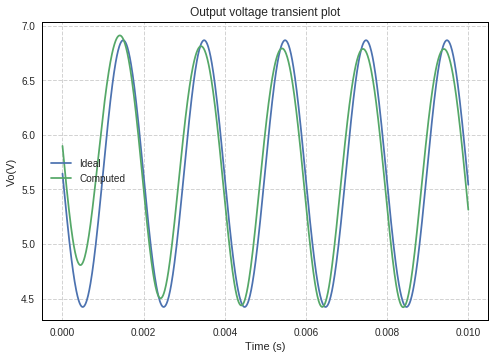

In [ ]:
# Input signal angular frequency
# Nominal value: 3150.0 rad/s
# You can use w=315.0 with tEnd=0.1 to see the effect of 
# the capacitor as high pass filter on both amplitude and phase
w = 3150.0

# Time data
# tEnd nominal value is 0.01 s
tEnd  = 0.01
t     = 0.0
tStep = tEnd/1000.0

# There is only one state variable
vci = VciQ

# Output vectors
tV =  []  # Time
viV = []  # Input voltage
voV = []  # Output voltage

# Circuit simulation
while t < tEnd:
    # Calculate circuit variables at current state
    vi  = Ai*np.sin(w*t)
    vbe = vi - vci
    ib  = Is*np.exp(vbe/nVt)
    ic = Beta*ib
    vo = Vdd - Rc*ic
    # Check saturation
    if vo < VceSat:
        vo = VceSat
        ic = (Vdd-VceSat)/Rc
    # Compute current on input capacitor Ci    
    ici = ib + vbe/Rb + (vbe-Vdd)/Ra 
    # Store data at current state
    tV.append(t)
    viV.append(vi)
    voV.append(vo)
    # Update Ci state variable (Euler)
    vci = vci + (ici/Ci)*tStep
    # Update time for next step
    t = t + tStep
    
# Compute ideal result from small signal calculations
if saturated:
    voV_ideal = VceSat * np.ones(len(viV))
else:
    voV_ideal = VceQ + gain*np.array(viV)
    
# Inform the calc module if we are inside colaboratory
calc.setColaboratory(colaboratory)
    
# Show results
if saturated:
    calc.plot11(tV,voV,"Output voltage transient plot"
           ,"Time (s)","Vo(V)")    
else:  
    calc.plot1n(tV,[voV_ideal,voV],"Output voltage transient plot"
           ,"Time (s)","Vo(V)",["Ideal","Computed"])  

That's all for this document

You can play with the document code changing circuit parameters to see how the response of the circuit changes

Beware that some asumptions are made during the calculations so, if you set too irreal values, the results you wil obtain won't make sense.

Some interesting tests you can do are:

* Change the input amplitude **Ai** to see the effect of cut-off and saturation

* Change the **Ra** , **Rb** and **Rc** values to modify the operating point

* Change the input signal **frequency** and the **simulation time** to see the filtering effect of the capacitor

If you make changes on the circuit you can use the **CRL+F9** combo to execute all the code cells. If you only change the last code cell, you don't need to execute again the previous ones.

<BR><BR><BR><BR><BR><BR>

## Document information

Copyright © Vicente Jiménez (2018)

Updated on 18/3/2018

This work is licensed under a [Creative Common Attribution-ShareAlike 4.0 International license](http://creativecommons.org/licenses/by-sa/4.0/). 

See my blogs [AIM65](http://aim65.blogspot.com.es/) (in spanish) and [R6500](http://r6500.blogspot.com.es/) (in english)

Other [Colaboratory](https://colab.research.google.com/drive/1-p9U6eK5CdJxYof2AZHV2IHO0lv_gzhM#scrollTo=CMWSJcb9ntOs) documents

Circuit drawings are drawn using [TinyCad](https://www.tinycad.net/)
